# Final Project
Violet Buxton-Walsh

ESPM 228: Advanced Topics in Biometeorology & Micrometeorology

Prof. Dennis Baldocchi

May 2021

In [1]:
import pandas as pd
import numpy as np
import math
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import geopandas as gpd
import sys
from scipy.special import erfcinv as erfcinv
import tqdm as tqdm
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import mean_squared_error as mse

#hacky latex bug fig
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

# Laguna Ek'Naab Pollen Data (Wahl et al. 2019)

In [2]:
pollen_counts = pd.read_csv('palynology.csv')
a = pollen_counts.drop('Unnamed: 4', axis = 1)
b = a.drop('Unnamed: 9', axis = 1)
c = b.drop('Unnamed: 11', axis = 1)
d = c.drop('Unnamed: 14', axis = 1)
e = d.drop('Unnamed: 16', axis = 1)
pollen_data = e.drop('Unnamed: 19', axis = 1)
pollen_data.head()

,Forest Taxa 1 (Urticales),Forest Taxa 2 (Celtis),Forest Taxa 3 (Ficus),Forest Taxa 4 (Melastomataceae/Combretaceae),Weedy Taxa 1 (Asteraceae),Weedy Taxa 2 (Ambrosia),Weedy Taxa 3 (Large Poaceae),Weedy Taxa 4 (Small Poaceae),Other Types,Forest Taxa Sum,Weedy Taxa Sum,Pollen Sum,Percent Foreset Taxa,Percent Weedy Taxa,Depth,Years Before Present
0,255,4,3,67,1,0,0,3,108,329,4,441,0.75,0.01,30,158
1,208,4,0,32,3,0,0,1,122,244,4,370,0.66,0.01,50,335
2,163,5,0,62,1,0,0,2,106,230,3,339,0.68,0.01,51,345
3,224,5,3,87,0,0,0,0,97,319,0,416,0.77,0.00,64,474
4,144,3,3,70,2,0,1,0,142,220,3,365,0.60,0.01,80,648


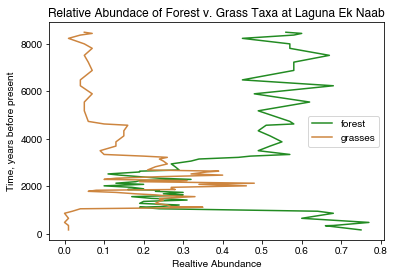

In [3]:
plt.plot(pollen_counts['Percent Foreset Taxa'], pollen_counts['Years Before Present'], c = 'forestgreen', label = 'forest')
plt.plot(pollen_counts['Percent Weedy Taxa'], pollen_counts['Years Before Present'], c = 'peru', label = 'grasses')
plt.legend()
plt.title('Relative Abundace of Forest v. Grass Taxa at Laguna Ek Naab')
plt.ylabel('Time, years before present')
plt.xlabel('Realtive Abundance')
plt.savefig('relabund.png')

# Calculate Gaussian Plume sigma values

In [4]:
def calc_sigmas(CATEGORY,x1):

    x=np.abs(x1)

    a=np.zeros(np.shape(x));
    b=np.zeros(np.shape(x));
    c=np.zeros(np.shape(x));
    d=np.zeros(np.shape(x));

    if CATEGORY == 1: # very unstable
        # vertical
        ind=np.where((x<100.) & (x>0.));
        a[ind]=122.800;b[ind]=0.94470;

        ind=np.where((x>=100.) & (x<150.));
        a[ind]=158.080;b[ind]=1.05420;

        ind=np.where((x>=150.) & (x<200.));
        a[ind]=170.220;b[ind]=1.09320;

        ind=np.where((x>=200.) & (x<250.));
        a[ind]=179.520;b[ind]=1.12620;

        ind=np.where((x>=250.) & (x<300.));
        a[ind]=217.410;b[ind]=1.26440;

        ind=np.where((x>=300.) & (x<400.));
        a[ind]=258.89;b[ind]=1.40940;

        ind=np.where((x>=400.) & (x<500.));
        a[ind]=346.75;b[ind]=1.7283;

        ind=np.where((x>=500.) & (x<3110.));
        a[ind]=453.85;b[ind]=2.1166;

        ind=np.where((x>=3110.));
        a[ind]=453.85;b[ind]=2.1166;

        # cross wind
        c[:]=24.1670;
        d[:]=2.5334;
        
    elif CATEGORY == 2: # moderately unstable
        # vertical
        ind=np.where((x<200.) & (x>0.));
        a[ind]=90.673;b[ind]=0.93198;

        ind=np.where((x>=200.) & (x<400.));
        a[ind]=98.483;b[ind]=0.98332;

        ind=np.where(x>=400.);
        a[ind]=109.3;b[ind]=1.09710;

        # cross wind
        c[:]=18.3330;
        d[:]=1.8096;

    elif CATEGORY == 3: # slightly unstable
        # vertical
        a[:]=61.141;
        b[:]=0.91465;
        # cross wind
        c[:]=12.5;
        d[:]=1.0857;
        
    elif CATEGORY == 4: # neutral
        # vertical
        ind=np.where((x<300.) &(x>0.));
        a[ind]=34.459;b[ind]=0.86974;

        ind=np.where((x>=300.) & (x<1000.));
        a[ind]=32.093;b[ind]=0.81066;

        ind=np.where((x>=1000.) & (x<3000.));
        a[ind]=32.093;b[ind]=0.64403;

        ind=np.where((x>=3000.) & (x<10000.));
        a[ind]=33.504;b[ind]=0.60486;

        ind=np.where((x>=10000.) & (x<30000.));
        a[ind]=36.650;b[ind]=0.56589;

        ind=np.where(x>=30000.);
        a[ind]=44.053;b[ind]=0.51179;

        # cross wind
        c[:]=8.3330;
        d[:]=0.72382;
        
    elif CATEGORY == 5: # moderately stable
        # vertical
        ind=np.where((x<100.) & (x>0.));
        a[ind]=24.26;b[ind]=0.83660;

        ind=np.where((x>=100.) & (x<300.));
        a[ind]=23.331;b[ind]=0.81956;

        ind=np.where((x>=300.) & (x<1000.));
        a[ind]=21.628;b[ind]=0.75660;

        ind=np.where((x>=1000.) & (x<2000.));
        a[ind]=21.628;b[ind]=0.63077;

        ind=np.where((x>=2000.) & (x<4000.));
        a[ind]=22.534;b[ind]=0.57154;

        ind=np.where((x>=4000.) & (x<10000.));
        a[ind]=24.703;b[ind]=0.50527;

        ind=np.where((x>=10000.) & (x<20000.));
        a[ind]=26.970;b[ind]=0.46713;

        ind=np.where((x>=20000.) & (x<40000.));
        a[ind]=35.420;b[ind]=0.37615;

        ind=np.where(x>=40000.);
        a[ind]=47.618;b[ind]=0.29592;

        # cross wind
        c[:]=6.25;
        d[:]=0.54287;
        
    elif CATEGORY == 6: # very stable
        # vertical
        ind=np.where((x<200.) & (x>0.));
        a[ind]=15.209;b[ind]=0.81558;

        ind=np.where((x>=200.) & (x<700.));
        a[ind]=14.457;b[ind]=0.78407;

        ind=np.where((x>=700.) & (x<1000.));
        a[ind]=13.953;b[ind]=0.68465;

        ind=np.where((x>=1000.) & (x<2000.));
        a[ind]=13.953;b[ind]=0.63227;

        ind=np.where((x>=2000.) & (x<3000.));
        a[ind]=14.823;b[ind]=0.54503;

        ind=np.where((x>=3000.) & (x<7000.));
        a[ind]=16.187;b[ind]=0.46490;

        ind=np.where((x>=7000.) & (x<15000.));
        a[ind]=17.836;b[ind]=0.41507;

        ind=np.where((x>=15000.) & (x<30000.));
        a[ind]=22.651;b[ind]=0.32681;

        ind=np.where((x>=30000.) & (x<60000.));
        a[ind]=27.074;b[ind]=0.27436;

        ind=np.where(x>=60000.);
        a[ind]=34.219;b[ind]=0.21716;

        # cross wind
        c[:]=4.1667;
        d[:]=0.36191;
    else:
        sys.exit()

    sig_z=a*(x/1000.)**b;
    sig_z[np.where(sig_z[:]>5000.)]=5000.;

    theta=0.017453293*(c-d*np.log(np.abs(x+1e-15)/1000.));
    sig_y=465.11628*x/1000.*np.tan(theta);

    return (sig_y,sig_z)

# Define Gaussian Plume deposition

In [5]:
def gauss_func(Q,u,dir1,x,y,z,xs,ys,H,Dy,Dz,STABILITY):
    u1=u;
    x1=x-xs; # shift the coordinates so that stack is centre point
    y1=y-ys; 

    # components of u in x and y directions
    wx=u1*np.sin((dir1-180.)*np.pi/180.);
    wy=u1*np.cos((dir1-180.)*np.pi/180.);

    # Need angle between point x, y and the wind direction, so use scalar product:
    dot_product=wx*x1+wy*y1;
    # product of magnitude of vectors:
    magnitudes=u1*np.sqrt(x1**2.+y1**2.); 

    # angle between wind and point (x,y)
    subtended=np.arccos(dot_product/(magnitudes+1e-15));
    # distance to point x,y from stack
    hypotenuse=np.sqrt(x1**2.+y1**2.);

    # distance along the wind direction to perpendilcular line that intesects
    # x,y
    downwind=np.cos(subtended)*hypotenuse;

    # Now calculate distance cross wind.
    crosswind=np.sin(subtended)*hypotenuse;

    ind=np.where(downwind>0.);
    C=np.zeros((len(x),len(y)));

    # calculate sigmas based on stability and distance downwind
    (sig_y,sig_z)=calc_sigmas(STABILITY,downwind);

    C[ind]=Q/(2.*np.pi*u1*sig_y[ind]*sig_z[ind]) \
    * np.exp(-crosswind[ind]**2./(2.*sig_y[ind]**2.))  \
    *(np.exp(-(z[ind]-H)**2./(2.*sig_z[ind]**2.)) + \
      np.exp(-(z[ind]+H)**2./(2.*sig_z[ind]**2.)) );
    
    return C

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    
    return y_smooth

# Define and plot a single footprint on the landscape

In [6]:
def single_footprint(aerosol_type):
    
    RH=0.90
    days = 20
    ONE_STACK = 1
    stacks = ONE_STACK
    Q=[40., 40., 40.]; #mass emitted per unit time
    H=[50., 50., 50.]; #stack height, m
    
    stack_x=[0., 1000., -200.];
    stack_y=[0., 250., -500.];
    
    times=np.mgrid[1:(days)*24+1:1]/24.;
    Dy=10.;
    Dz=10.;
    
    #Dry diameter of aerosol particles assumed (m)
    genera = {'urt':1e-5,'celt':2e-5,'fic':8e-6,'m_c':2e-5, 
              'ast':2e-5,'amb':2e-5,'pS':2e-5, 'pL':4e-5}
    dry_size = genera[aerosol_type]

    # Resolution of the model in both x and y directions,
    # x-grid is same as y-grid
    dxy=100;          
    dz=10;
    
    # Solve on a 10km^2 domain
    x=np.mgrid[-10000:10000+dxy:dxy]; 
    y=x;   
    
    # SECTION 2: Act on the configuration information
    stab1 = 1
    stability = stab1*np.ones((days*24,1));
    C1 = np.zeros((len(x),len(y),days*24)); #array to store data, initialised to be zero
    [x,y] = np.meshgrid(x,y);               #x and y defined at all positions on the grid
    z = np.zeros(np.shape(x));              #z is defined to be at ground level.

    # Set the wind based on input flags (use prevailing ~5m/s Easterly winds)
    wind_speed = 5. * np.ones((days*24,1)); # m/s
    wind_dir = -np.sqrt(2.)  * erfcinv(2.*np.random.rand(24*days,1))*40.; #norminv(rand(days.*24,1),0,40);
    
    #add on the prevailing wind direction, i.e.
    #wind_dir=wind_dir+200;
    wind_dir[np.where(wind_dir>=360.)] = np.mod(wind_dir[np.where(wind_dir>=360)],360);

    #SECTION 3: Main loop
    C1=np.zeros((len(x),len(y),len(wind_dir)))
    for i in tqdm.tqdm(range(0,len(wind_dir))):
        for j in range(0,stacks):
            C=np.ones((len(x),len(y)))
            C=gauss_func(Q[j],wind_speed[i],wind_dir[i],x,y,z,stack_x[j],stack_y[j],H[j],Dy,Dz,stability[i]);
            C1[:,:,i] = C1[:,:,i] + C;
    
    c = np.mean(C1,axis=2)*1e6
    return c

# Find land use scenario/time period by pollen type abundances

In [7]:
#Define portions of the dataset to be different land use scenarios
A = range(0,14)
B = range(14,30)
C = range(30,69)

#Establish the pollen types being considered and added to the forest
type_list = ['Forest Taxa 1 (Urticales)','Forest Taxa 2 (Celtis)',
       'Forest Taxa 3 (Ficus)', 'Forest Taxa 4 (Melastomataceae/Combretaceae)',
       'Weedy Taxa 1 (Asteraceae)', 'Weedy Taxa 2 (Ambrosia)',
       'Weedy Taxa 3 (Large Poaceae)', 'Weedy Taxa 4 (Small Poaceae)']

def scenario_abundances(scenario):
    
    assert scenario == A or scenario == B or scenario == C
    
    type_mean = []
    
    for species in type_list:
        species_abunds = []
        
        for row in scenario:
            type_time_abund = (pollen_data[species][row] / pollen_data['Pollen Sum'][row]) * 100
            species_abunds.append(type_time_abund)

        type_mean.append(np.mean(species_abunds))
         
    #Returns the average relative abundace for a given pollen type within the specified scenario (aka timeframe)
    return(type_mean)

# Simulate land use scenarios

In [8]:
def make_forest(scenario):

    #Assign each plant type its averaged relative abundance for the time scenario
    urt, celt, fic, m_c, ast, amb, pL, pS = scenario_abundances(scenario)
    plant_type = {urt:['urt','darkorange'], celt:['celt', 'burlywood'], fic:['fic', 'midnightblue'],
                 m_c: ['m_c', 'darkolivegreen'], ast: ['ast', 'olivedrab'], amb: ['amb','chocolate'],
                 pL: ['pL', 'orchid'], pS: ['pS', 'forestgreen']}
    
    seedX = [1,2,3,4,5,6,7,8]
    seedY = [9,10,11,12,13,14,15,16]
    
    #Construct some number of random pts (x,y) for each pollen type based on its abundance
    type_dict = {}
    
    #scaling = 1000
    
    for abund in scenario_abundances(scenario):
        x = []
        y = []
        
        num_of_pts = int(np.round(abund * 100))

        np.random.seed(seedX)
        x.append(np.random.rand(num_of_pts) * 10000)
        np.random.seed(seedY)
        y.append(np.random.rand(num_of_pts) * 10000)
        
        plt.scatter(x, y, c = plant_type[abund][1], label = plant_type[abund][0], alpha = 0.5)
        
        type_dict[plant_type[abund][0]] = x, y

#     #Construct a circle centered at p
#     p = Point(5000, 5000)
#     circle = p.buffer(500)
#     circle_pts = circle.exterior.coords
#     lake = Polygon(circle_pts)
#     xdim,ydim = lake.exterior.xy

#     #Plot the circle together with the random points (plants and lake)
#     plt.plot(xdim,ydim)
    plt.xlabel('X distance (m)')
    plt.ylabel('Y distance (m)')
    plt.title('Scenario ' + str(scenario))
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    plt.savefig('forest.png')
    plt.show()
    
    return(type_dict)

# Plot composite footprints of all individuals in a scenario

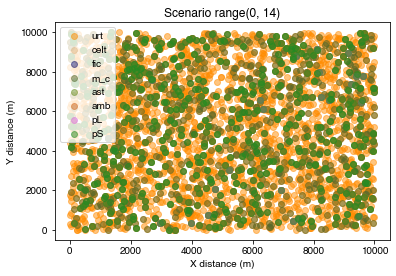

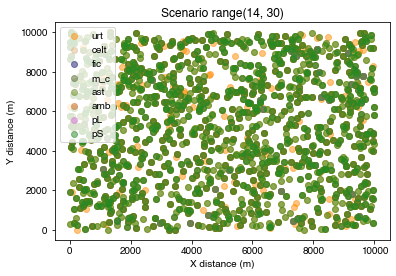

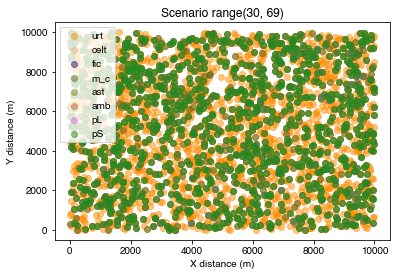

In [9]:
plantsA = make_forest(A)
plantsB = make_forest(B)
plantsC = make_forest(C)

In [10]:
# plants = plants dict

def get_plumes(plants):
    
    plumes = []
            
    for species in plants.keys():
        
        plume = single_footprint(species)
        plumes.append(plume)
        
    # list of plumes for each species
    return plumes    

def composite_plumes(plants, plumes):
    
    # size of canvas
    Ncanvas = 10000
    Nspecies = 8
        
    canvases = np.zeros((Ncanvas, Ncanvas, Nspecies))

    # my location variables, to be returned
    # consists of plants_xs for each plant species
    all_plant_xs = []
    all_plant_ys = []

    for species_index, species in enumerate(plants.keys()):
    #for species_index, species in enumerate(["celt"]):
        
        plume = plumes[species_index] 
        
        dim = plume.shape[0]
    
        # xs and ys for an individual species
        plant_xs = []
        plant_ys = []

        #### 
    
        plant_locs = []
        origin_pts_x = []
        origin_pts_y = []
        
        for i in range(0, len(plants[species][0][0]) - 1):
            origin_pts_x.append(plants[species][0][0][i])
            origin_pts_y.append(plants[species][1][0][i])
            
        for i in range(0, len(origin_pts_x)):
            loc_of_individual = (origin_pts_x[i], origin_pts_y[i])
            plant_locs.append(loc_of_individual)
            
        ####
            
        for (plant_x, plant_y) in plant_locs:
                        
            plant_xs.append(plant_x)
            plant_ys.append(plant_y)
            
            # iterate over all points in the plume
            for plume_x in range(0,dim):
                for plume_y in range(0,dim):
                    
                    # find corresponding point on canvas
                    scaling = 1 # plume scale vs. canvas scale
                    canvas_x = int( scaling*(plume_x - dim/2) + plant_x)
                    canvas_y = int( scaling*(plume_y - dim/2) + plant_y)
                    #print(canvas_x, canvas_y, species_index)
                    
                    # checking if we're on canvas
                    if 0 <= canvas_x < Ncanvas and 0 <= canvas_y < Ncanvas:
                        canvases[canvas_x, canvas_y, species_index] += plume[plume_x,plume_y]
                        
        all_plant_xs.append(plant_xs)
        all_plant_ys.append(plant_ys)
        
    return canvases, all_plant_xs, all_plant_ys

In [11]:
plumesA = get_plumes(plantsA)
plumesB = get_plumes(plantsB)
plumesC = get_plumes(plantsC)

concA = composite_plumes(plantsA,plumesA)
concB = composite_plumes(plantsB,plumesB)
concC = composite_plumes(plantsC,plumesC)

100%|██████████| 480/480 [00:07<00:00, 60.97it/s]


In [12]:
canvasesA = concA[0]
canvasesB = concB[0]
canvasesC = concC[0]

# individual species
# celtA = canvases[:,:,1]

# total species
total_concA = np.sum(canvasesA,axis=2)
total_concB = np.sum(canvasesB,axis=2)
total_concC = np.sum(canvasesC,axis=2)

# Generate composite plume plots

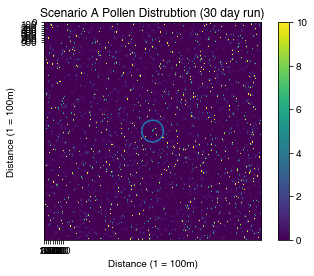

In [13]:
plt.imshow(total_concA,vmax=10)
plt.xticks(np.arange(0,1000, step = 100))
plt.yticks(np.arange(0,1000, step = 100))
plt.xlabel('Distance (1 = 100m)')
plt.ylabel('Distance (1 = 100m)')
plt.title('Scenario A Pollen Distrubtion (30 day run)')
plt.colorbar()

#Construct a circle centered at p
p = Point(5000, 5000)
circle = p.buffer(500)
circle_pts = circle.exterior.coords
lake = Polygon(circle_pts)
xdim,ydim = lake.exterior.xy

#Plot the circle together with the random points (plants and lake)
plt.plot(xdim,ydim)
plt.savefig("a-.jpeg")

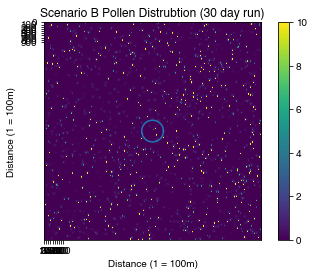

In [14]:
plt.imshow(total_concB,vmax=10)
plt.xticks(np.arange(0,1000, step = 100))
plt.yticks(np.arange(0,1000, step = 100))
plt.xlabel('Distance (1 = 100m)')
plt.ylabel('Distance (1 = 100m)')
plt.title('Scenario B Pollen Distrubtion (30 day run)')
plt.colorbar()

#Construct a circle centered at p
p = Point(5000, 5000)
circle = p.buffer(500)
circle_pts = circle.exterior.coords
lake = Polygon(circle_pts)
xdim,ydim = lake.exterior.xy

#Plot the circle together with the random points (plants and lake)
plt.plot(xdim,ydim)
plt.savefig("b-.jpeg")

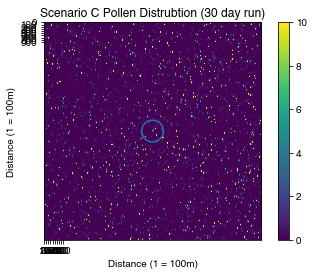

In [15]:
c_plot = plt.imshow(total_concC,vmax=10)
plt.xticks(np.arange(0,1000, step = 100))
plt.yticks(np.arange(0,1000, step = 100))
plt.xlabel('Distance (1 = 100m)')
plt.ylabel('Distance (1 = 100m)')
plt.title('Scenario C Pollen Distrubtion (30 day run)')
plt.colorbar()

#Construct a circle centered at p
p = Point(5000, 5000)
circle = p.buffer(500)
circle_pts = circle.exterior.coords
lake = Polygon(circle_pts)
xdim,ydim = lake.exterior.xy

#Plot the circle together with the random points (plants and lake)
plt.plot(xdim,ydim)
plt.savefig("c-.jpeg")

In [16]:
##REMINDERS OF HOW TO INDEX CANVASES ARRAY

# plot all plant locations
# for plant_index in range(0,1):
#     xs = concA[1][plant_index]
#     ys = concA[2][plant_index]
    
#plt.scatter(xs,ys,label=f"planet index {plant_index}")

    #plt.legend()
#plt.colorbar()

# plot plumes
# plt.imshow(canvasesC[:,:,0],vmin=0,vmax=1,zorder=10)

# celtA = canvasesA[:,:,1]
# celtA

# Calculate plume area over lake
#### Proxy for lake area deposition

In [17]:
#Pollen in square lake approximation
spec_A_sum = []
spec_B_sum = []
spec_C_sum = []
lake_totA = []
lake_totB = []
lake_totC = []
rel_tot_A = []
rel_tot_B = []
rel_tot_C = []

for species in range(0,7):
    spec_A_sum.append(canvasesA[4500:5500,4500:5500,species])
    spec_B_sum.append(canvasesB[4500:5500,4500:5500,species])
    spec_C_sum.append(canvasesC[4500:5500,4500:5500,species])

for arr in range(0,7):
    lake_totA.append(np.sum(spec_A_sum[arr]))
    lake_totB.append(np.sum(spec_B_sum[arr]))
    lake_totC.append(np.sum(spec_C_sum[arr]))
    
for spec_total in range(0,7):
    rel_tot_A.append(lake_totA[spec_total]/np.sum(lake_totA))
    rel_tot_B.append(lake_totB[spec_total]/np.sum(lake_totB))
    rel_tot_C.append(lake_totC[spec_total]/np.sum(lake_totC))

# Compare this to the original dataset


In [18]:
A = pollen_counts[0:14]
B = pollen_counts[14:30]
C = pollen_counts[30:69]

In [19]:
forA_calc = np.mean(rel_tot_A[0:4])
weedA_calc = np.mean(rel_tot_A[4:8])
forA_true = np.mean(A['Percent Foreset Taxa'])
weedA_true = np.mean(A['Percent Weedy Taxa'])

forB_calc = np.mean(rel_tot_B[0:4])
weedB_calc = np.mean(rel_tot_B[4:8])
forB_true = np.mean(B['Percent Foreset Taxa'])
weedB_true = np.mean(B['Percent Weedy Taxa'])

forC_calc = np.mean(rel_tot_C[0:4])
weedC_calc = np.mean(rel_tot_C[4:8])
forC_true = np.mean(C['Percent Foreset Taxa'])
weedC_true = np.mean(C['Percent Weedy Taxa'])

In [20]:
a_for = forA_calc, forA_true
b_for = forB_calc, forB_true
c_for = forC_calc, forC_true

a_w = weedA_calc, weedA_true
b_w = weedB_calc, weedB_true
c_w = weedC_calc, weedC_true

AA = a_for, a_w 
BB = b_for, b_w
CC = c_for, c_w

AA, BB, CC

(((0.23034556685704904, 0.45285714285714296),
  (0.026205910857267884, 0.12214285714285714)),
 ((0.1552436545302084, 0.22000000000000003), (0.1263417939597221, 0.255625)),
 ((0.2494340710346083, 0.4317948717948718),
  (0.0007545719538556277, 0.15076923076923077)))

In [21]:
AA, BB, CC = [[0.23034556685704904, 0.45285714285714296, 0.026205910857267884, 0.12214285714285714],
              [0.1552436545302084, 0.22000000000000003, 0.1263417939597221, 0.255625],
              [0.2494340710346083, 0.4317948717948718, 0.0007545719538556277, 0.15076923076923077]]

In [22]:
df = pd.DataFrame(columns = ['Forest (modeled)', 'Forest actual', 'Weeds (modeled)', 'Weeds actual'], 
                  index = ['A', 'B', 'C'])
df['Forest (modeled)'] = AA[0], BB[0], CC[0]
df['Forest actual'] = AA[1], BB[1], CC[1]
df['Weeds (modeled)'] = AA[2], BB[2], CC[2]
df['Weeds actual'] = AA[3], BB[3], CC[3]
df['Modeled/Actual (Forest)'] = df['Forest (modeled)'] / df['Forest actual']
df['Modeled/Actual (Weeds)'] = df['Weeds (modeled)'] / df['Weeds actual']

In [23]:
df

,Forest (modeled),Forest actual,Weeds (modeled),Weeds actual,Modeled/Actual (Forest),Modeled/Actual (Weeds)
A,0.230346,0.452857,0.026206,0.122143,0.508650,0.214551
B,0.155244,0.220000,0.126342,0.255625,0.705653,0.494247
C,0.249434,0.431795,0.000755,0.150769,0.577668,0.005005


In [24]:
mse_forest = mse([.452857,.220000,.431795], [.230346,.155244,.249434])
mse_grass = mse([0.122143, 0.255625, 0.150769], [0.026206, 0.126342, 0.000755])
mse_forest, mse_grass

(0.028986672992666673, 0.016140734084666663)

In [25]:
mse_a = mse([0.452857, 0.122143],[0.230346, 0.026206])
mse_b = mse([0.220000, 0.255625],[0.155244, 0.126342])
mse_c = mse([0.431795, 0.150769],[0.249434, 0.000755])
mse_a, mse_b, mse_c

(0.029357526545000005, 0.010453716812499998, 0.027879867258499995)